## Introduction to AWS Open Datasets

### Questions
- What are some of the ways to access data on the cloud?
- What are some open source GIS tools for manipulating data?

### Objectives
- Learn how to access data through the AWS Open Dataset Program
- Learn about rasterio for analyzing raster images

In [8]:
# use preview https://landsatonaws.com/L8/227/065/

In [9]:
# talk a bit about thre 

In [3]:
import rasterio
import rasterio.plot
import pyproj
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

/srv/conda/envs/notebook/lib/python3.8/site-packages/rasterio/plot.py:260: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if len(arr.shape) is 2:


In [4]:
print('Landsat on AWS:')
filepath = 'http://landsat-pds.s3.amazonaws.com/c1/L8/227/065/LC08_L1TP_227065_20200608_20200608_01_RT/LC08_L1TP_227065_20200608_20200608_01_RT_B4.TIF'
with rasterio.open(filepath) as src:
    print(src.profile)

Landsat on AWS:
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7621, 'height': 7761, 'count': 1, 'crs': CRS.from_epsg(32621), 'transform': Affine(30.0, 0.0, 573285.0,
       0.0, -30.0, -683685.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


In [5]:
# describe what you see

In [6]:
# Use Level 1TP datasets, orthorectified, map-projected images containing radiometrically calibrated data.

In [7]:
# print rgb - true color

In [8]:
file_list = ['http://landsat-pds.s3.amazonaws.com/c1/L8/227/065/LC08_L1TP_227065_20200608_20200608_01_RT/LC08_L1TP_227065_20200608_20200608_01_RT_B1.TIF', 
             'http://landsat-pds.s3.amazonaws.com/c1/L8/227/065/LC08_L1TP_227065_20200608_20200608_01_RT/LC08_L1TP_227065_20200608_20200608_01_RT_B2.TIF', 
             'http://landsat-pds.s3.amazonaws.com/c1/L8/227/065/LC08_L1TP_227065_20200608_20200608_01_RT/LC08_L1TP_227065_20200608_20200608_01_RT_B3.TIF',
             'http://landsat-pds.s3.amazonaws.com/c1/L8/227/065/LC08_L1TP_227065_20200608_20200608_01_RT/LC08_L1TP_227065_20200608_20200608_01_RT_B4.TIF',
            'http://landsat-pds.s3.amazonaws.com/c1/L8/227/065/LC08_L1TP_227065_20200608_20200608_01_RT/LC08_L1TP_227065_20200608_20200608_01_RT_B5.TIF']

# Read metadata of first file
with rasterio.open(file_list[0]) as src0:
    meta = src0.meta

# Update meta to reflect the number of layers
meta.update(count = len(file_list))

# Read each layer and write it to stack
with rasterio.open('stack.tif', 'w', **meta) as dst:
    for id, layer in enumerate(file_list, start=1):
        with rasterio.open(layer) as src1:
            dst.write_band(id, src1.read(1))

In [9]:
src = rasterio.open("stack.tif")
# Read the grid values into numpy arrays
red = src.read(3)
green = src.read(2)
blue = src.read(1)

# Function to normalize the grid values
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

# Normalize the bands
redn = normalize(red)
greenn = normalize(green)
bluen = normalize(blue)

print("Normalized bands")
print(redn.min(), '-', redn.max(), 'mean:', redn.mean())
print(greenn.min(), '-', greenn.max(), 'mean:', greenn.mean())
print(bluen.min(), '-', bluen.max(), 'mean:', bluen.mean())

Normalized bands
0.0 - 1.0 mean: 0.1465506687307775
0.0 - 1.0 mean: 0.15988139476286892
0.0 - 1.0 mean: 0.15586194797639435


In [10]:
# Create RGB natural color composite 
# not a good idea for the whole scene
#rgb = np.dstack((redn, greenn, bluen))

# Let's see how our color composite looks like
#plt.imshow(rgb)

Decimation factor= 9


Text(0, 0.5, 'Row #')

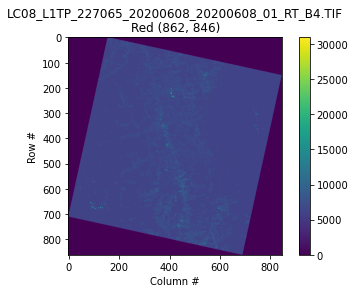

In [11]:
# Use the same example image:
date = '2020-06-08'
url = 'http://landsat-pds.s3.amazonaws.com/c1/L8/227/065/LC08_L1TP_227065_20200608_20200608_01_RT/'
redband = 'LC08_L1TP_227065_20200608_20200608_01_RT_B{}.TIF'.format(4)
nirband = 'LC08_L1TP_227065_20200608_20200608_01_RT_B{}.TIF'.format(5)

with rasterio.open(url+redband) as src:
    profile = src.profile
    oviews = src.overviews(1) # list of overviews from biggest to smallest
    oview = oviews[1]  # Use second-highest resolution overview
    print('Decimation factor= {}'.format(oview))
    red = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

plt.imshow(red)
plt.colorbar()
plt.title('{}\nRed {}'.format(redband, red.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')

Text(0, 0.5, 'Row #')

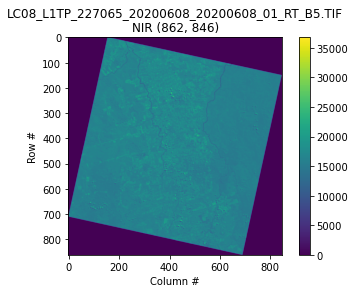

In [12]:
with rasterio.open(url+nirband) as src:
    oviews = src.overviews(1) # list of overviews from biggest to smallest
    oview = oviews[1]  # Use second-highest resolution overview
    nir = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

plt.imshow(nir)
plt.colorbar()
plt.title('{}\nNIR {}'.format(nirband, nir.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')

<ipython-input-13-20c0ccfacde0>:5: RuntimeWarning: invalid value encountered in true_divide
  ndvi = (nir - red) / (nir + red)


Text(0, 0.5, 'Row #')

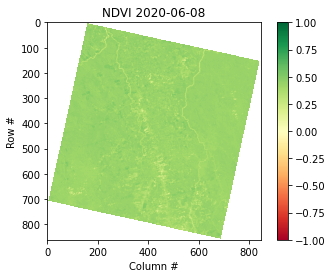

In [13]:
def calc_ndvi(nir,red):
    '''Calculate NDVI from integer arrays'''
    nir = nir.astype('f4')
    red = red.astype('f4')
    ndvi = (nir - red) / (nir + red)
    return ndvi

ndvi = calc_ndvi(nir,red)
plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar()
plt.title('NDVI {}'.format(date))
plt.xlabel('Column #')
plt.ylabel('Row #')

##### ref - https://geohackweek.github.io/raster/04-workingwithrasters/